In [ ]:
#https://towardsdatascience.com/quora-insincere-questions-classification-d5a655370c47
#https://www.kaggle.com/rahulrky/pre-processing-techniques-for-textual-data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

In [2]:
import os
import csv
import json


In [3]:
def read_data(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter="\t")

    X = []
    Y = []
    i = 0
    print('Reading articles...')
    for row in read_tsv:
        #print(row)
        # Opening JSON file
        if(row[0][:]!='ID'):

            #if(i%1000==0):
            #    print('Reading article ', i)

            json_file = open('data/jsons/'+row[0][:]+'.json',)
            #print(row[1][:])
            # Reading JSON file
            data = json.load(json_file)

            Y.append(data['bias'])
            X.append(data['content'])


            #print(target)
            #print(text)

            # Closing file
            json_file.close()
            i = i + 1

    tsv_file.close()
    print('done')
    
    return X, Y


In [4]:
print('Load training dataset')
train_data_path = "data/splits/random/train.tsv"
X_train, Y_train = read_data(train_data_path)

# dictionary of lists 
dict_train = {'content': X_train, 'bias': Y_train} 
train_df = pd.DataFrame(dict_train)
#df_train.to_csv('data/splits/media/train_data.tsv', index=False)

print('Load validation dataset')
val_data_path = "data/splits/random/valid.tsv"
X_val, Y_val = read_data(val_data_path)

# dictionary of lists 
dict_val = {'content': X_val, 'bias': Y_val} 
val_df = pd.DataFrame(dict_val)
#df_val.to_csv('data/splits/media/val_data.tsv', index=False)

print('Load test dataset')
test_data_path = "data/splits/random/test.tsv"
X_test, Y_test = read_data(test_data_path)

# dictionary of lists 
dict_test = {'content': X_test, 'bias': Y_test} 
test_df = pd.DataFrame(dict_test)

#df_test.to_csv('data/splits/media/test_data.tsv', index=False)


Load training dataset
Reading articles...
done
Load validation dataset
Reading articles...
done
Load test dataset
Reading articles...
done


In [6]:
print("Train shape : ", train_df.shape)
print("Val shape : ", val_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (27978, 2)
Val shape :  (6996, 2)
Test shape :  (1300, 2)


In [12]:
## vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df = 10, max_features = 100000, analyzer = "word", ngram_range = (1, 2), stop_words = 'english', lowercase = True)
train_vc = tfidf_vc.fit_transform(train_df["content"])
val_vc = tfidf_vc.transform(val_df["content"])
test_vc = tfidf_vc.transform(test_df["content"])

In [13]:
model = LogisticRegression(solver = "sag")
model = model.fit(train_vc, train_df.bias)
train_pred = model.predict(train_vc)
val_pred = model.predict(val_vc)

In [14]:
from sklearn.metrics import f1_score
train_cv = f1_score(train_df.bias, train_pred, average = "weighted")
print(train_cv)
val_cv = f1_score(val_df.bias, val_pred, average = "weighted")
print(val_cv)

0.8960101576837981
0.7416258859576307


In [15]:
test_pred = model.predict(test_vc)
test_cv = f1_score(test_df.bias, test_pred, average = "weighted")
print(test_cv)

0.7166889447795753


In [22]:
idx = 500
c = make_pipeline(tfidf_vc, model)
class_names = ["left", "center", "right"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(val_df["content"][idx], c.predict_proba, num_features = 100)

print("Article: \n", val_df["content"][idx])
print("Probability (Left) =", c.predict_proba([val_df["content"][idx]])[0, 0])
print("Probability (Center) =", c.predict_proba([val_df["content"][idx]])[0, 1])
print("Probability (Right) =", c.predict_proba([val_df["content"][idx]])[0, 2])
print("True Class is:", class_names[val_df["bias"][idx]])

Article: 
 America ’ s top intelligence official acknowledged Tuesday that President Obama and other senior White House officials were well aware of U.S. surveillance activities targeting leaders of friendly foreign nations — a stark contradiction of the administration ’ s insinuation in recent days that the president was unaware of such spying .
Director of National Intelligence James R. Clapper described the targeting of foreign leaders , including American allies , as a “ fundamental ” aspect of intelligence gathering , and said neither the CIA nor the National Security Agency can tap into a given leader ’ s private communications without White House oversight .
His testimony , made during a series of tacit exchanges Tuesday with members of the House Select Committee on Intelligence , came as all sides in Congress have begun seriously examining legislative proposals that would rein in the legal framework surrounding the NSA ’ s snooping programs .
Two lawmakers introduced a bill Tue

In [40]:
exp.as_list()

[('Mr', -0.05695599627763948),
 ('Obama', -0.042957747390489416),
 ('said', 0.027714688580923005),
 ('don', -0.015775956630491274),
 ('America', -0.015568799739677324),
 ('briefings', 0.014700121721037015),
 ('Merkel', 0.014029484243323733),
 ('NSA', -0.013892323370588522),
 ('officials', 0.013528280763037602),
 ('White', 0.013236181847265925),
 ('hearing', 0.013012834632073141),
 ('Democrat', -0.01056560965549244),
 ('Washington', 0.010264747693553592),
 ('American', -0.010094009031810404),
 ('anonymity', -0.008819782945735388),
 ('say', 0.008252921167523694),
 ('program', 0.007547119387677394),
 ('Rogers', -0.007392478239890808),
 ('lawmakers', 0.0071343970521168905),
 ('United', -0.00699024045497431),
 ('Gen', -0.006500295001926182),
 ('reports', 0.006302796644484962),
 ('claimed', -0.006110007154962492),
 ('Mrs', -0.005856534732687892),
 ('sought', 0.005689725215072239),
 ('Clapper', -0.005610711687999836),
 ('snooping', -0.005451247633144098),
 ('allies', 0.005446240167816768),
 (

In [43]:
print('Original prediction:',  model.predict_proba(val_vc[idx])[0, 2])
tmp = val_vc[idx].copy()
tmp[0, tfidf_vc.vocabulary_['mr']] = 0
tmp[0, tfidf_vc.vocabulary_['obama']] = 0
print('Prediction after removing some features:', model.predict_proba(tmp)[0, 2])
print('Difference:', model.predict_proba(tmp)[0, 2] - model.predict_proba(val_vc[idx])[0, 2])

Original prediction: 0.7862135540280013
Prediction after removing some features: 0.6995321929233037
Difference: -0.0866813611046976


In [31]:
exp.show_in_notebook(text=False)

In [35]:
exp.show_in_notebook(text=val_df["content"][idx], labels=(1,))

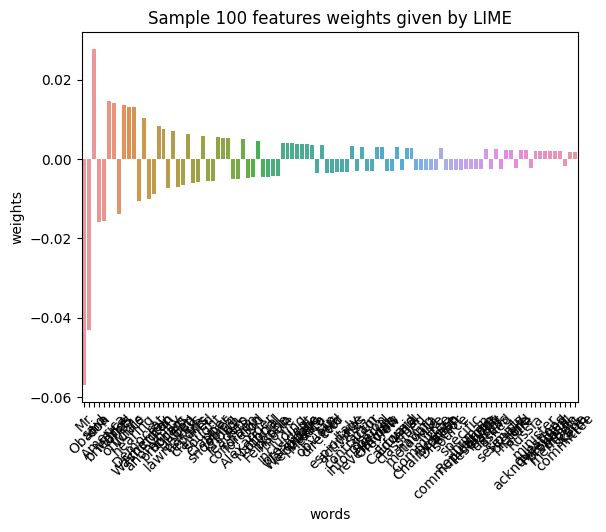

In [38]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(100))
plt.show()